<a href="https://colab.research.google.com/github/snel-repo/ComputationThruDynamicsBenchmark/blob/main/examples/WorkshopNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import random
import dotenv
import pathlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch

# for reproducibility
random.seed(2024)
dotenv.load_dotenv(override=True)

HOME_DIR = os.getenv("HOME_DIR")

from ctd.comparison.analysis.tt.tt import Analysis_TT

## CORRECTED OBS

The delivery of the inputs has to be spread out in time to allow for memorization - implement here at randomly spaced out times, and as a poisson process (can also try according to a uniform random distribution, but here we want to be as close as possible to PClicks)

* The inter-arrival times are distributed exponentially, and the arrivals themselves as a gamma distribution

* Train on the optimal parameters obtained for the last task (at least first): 1000 samples, 1000 timesteps

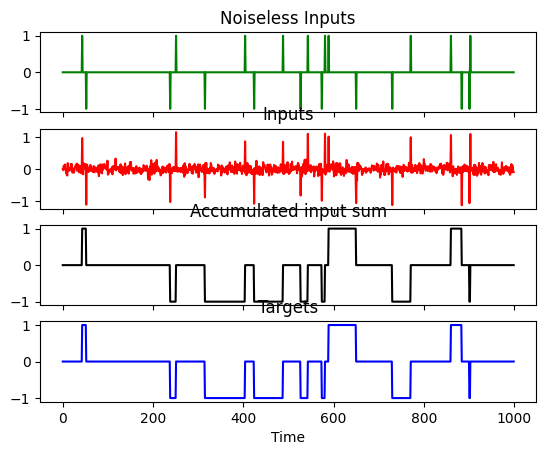

In [2]:
from ctd.task_modeling.task_env.task_env import OneBitSum

OBS = OneBitSum(n_timesteps=1000,
                noise=0.1,
                switch_prob=0.05,
                n=20,                  # this is the average number of pulses in a trial
                limits=(-1, 1),
                poisson=True)

OBS.render()

### NODE: latent size = 2

* weight decay 1e-9
* learning rate 1e-3
* 300 epochs
* n=20 (average pulses in trial)

#### For now have to go into the source code if you wanted to change limits (-1, 1) - something weird goes on when including the parameter in the configs


In [3]:
path = "/scratch/network/ad2002/content/trained_models/task-trained/20240422_NODE_OBS_300epoch/latent_size=2 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.001 max_epochs=300 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS_2D = Analysis_TT(run_name = "node_obs_test", filepath = path)

Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


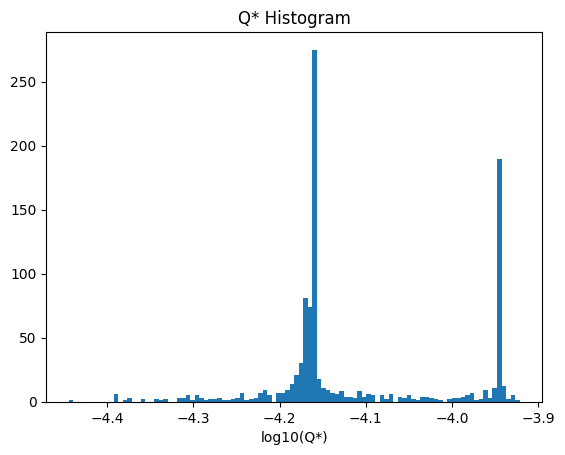

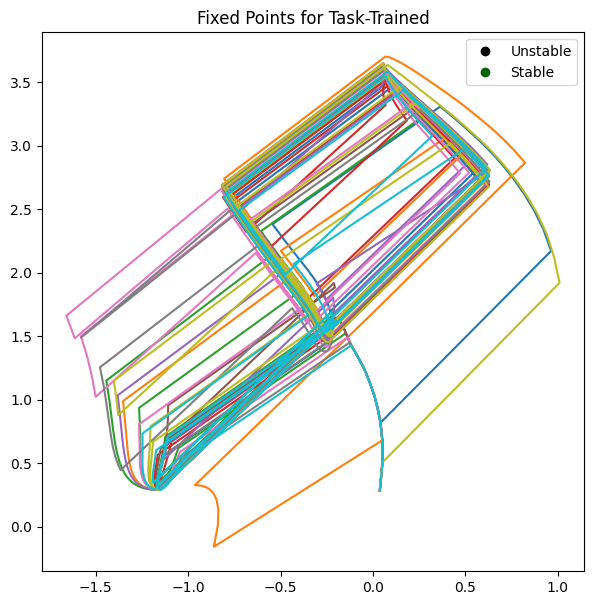

In [4]:
# INPUTS: you can pass your own into the FPF, but it should not have the same shape as the internal inputs used
# in the actual FPF algorithm. Shape should be (n_trials, n_timesteps, n_input_channels)
# To return the latter and plot the velocity field with the same internal inputs, set return_points=True

# Ex: you can pass in the zero inputs below, and it will return the internal inputs that the FPF has transformed
# inputs to accounting for time and total trials. 
# OR you can set inputs to None, and will return random inputs that the FPF internally used

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,1))
# the velocity_vectors do end up using my_inputs (or at least a repeat of their first element)

velocity_vectors, xstar, q_flag, color = node_OBS_2D.plot_fps(
    inputs= my_inputs,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=1000,
    learning_rate=1e-5,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-6,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True
)

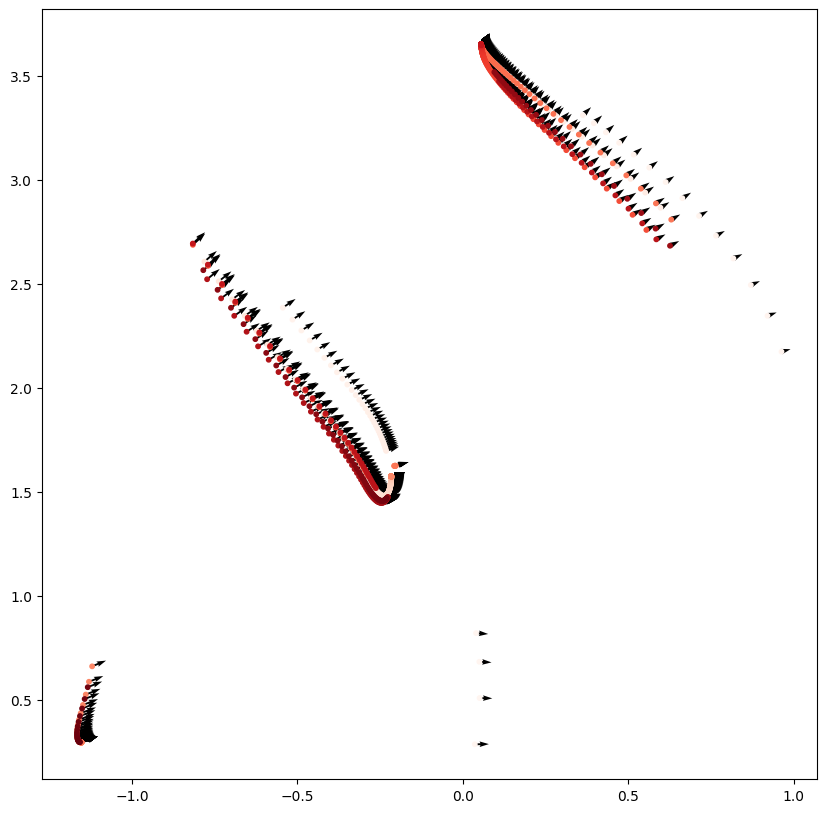

In [29]:
# plot the internal velocities along the trajectory

latents = node_OBS_2D.get_latents_noiseless()
latents = latents[0,:,:].detach().numpy()
vels = velocity_vectors.detach().numpy()

plt.figure(figsize=(10, 10))
plt.quiver(latents[:,0], latents[:,1], vels[:,0], vels[:,1])
plt.scatter(latents[:,0], latents[:,1], s=10, c=np.arange(latents.shape[0]), cmap='Reds')

/home/ad2002/gnode/ctd/comparison/analysis/tt/tt.py:466: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(*latents[i].T, c=colors_target[i], cmap=cmap_target)


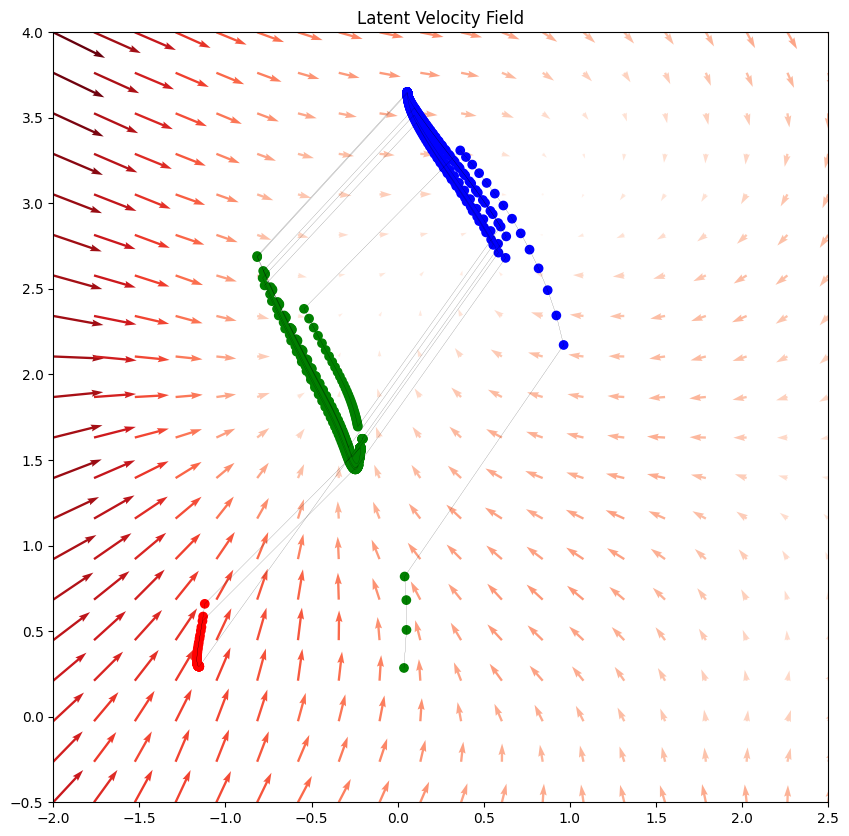

In [6]:
# plot the 2D velocity field
# -1 red, 0 green, 1 blue

num_points = 20
latent_range = [[-2,2.5], [-.5,4]]

my_inputs = 1*torch.ones(num_points**2, 1)

fig, ax = node_OBS_2D.plot_velocity_field_non_pca(my_inputs, latent_range, num_points, xstar, q_flag, color, 
                                        num_traj=1, cmap=plt.cm.Reds, return_animation=True, validate_input_val=None)

# ics has shape (trial, 1) - always initialized to 0
# input needs to have dimensions (trials, time, channels) to work with wrapper
# 1000 - n_samples from task datamodule_train configs - here I just need 1 sample (this is the number of trials)
# 1000 - n_timesteps from env_task configs

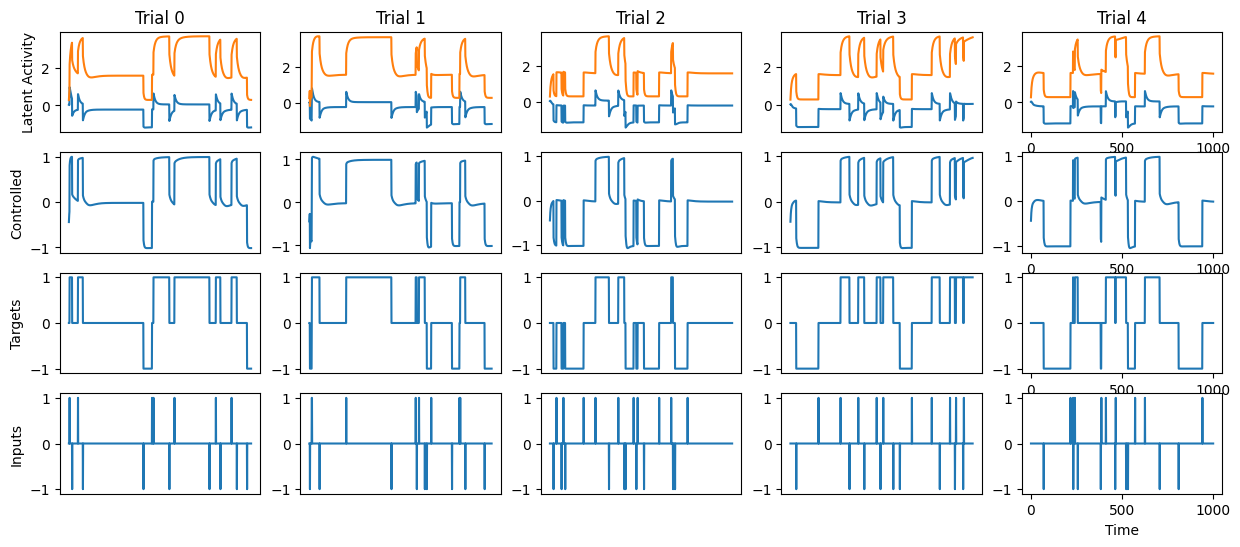

In [7]:
node_OBS_2D.plot_trial_io_no_pca(num_trials=5, latent_size=2)

Maximum iteration count reached. Terminating.
Found 500 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


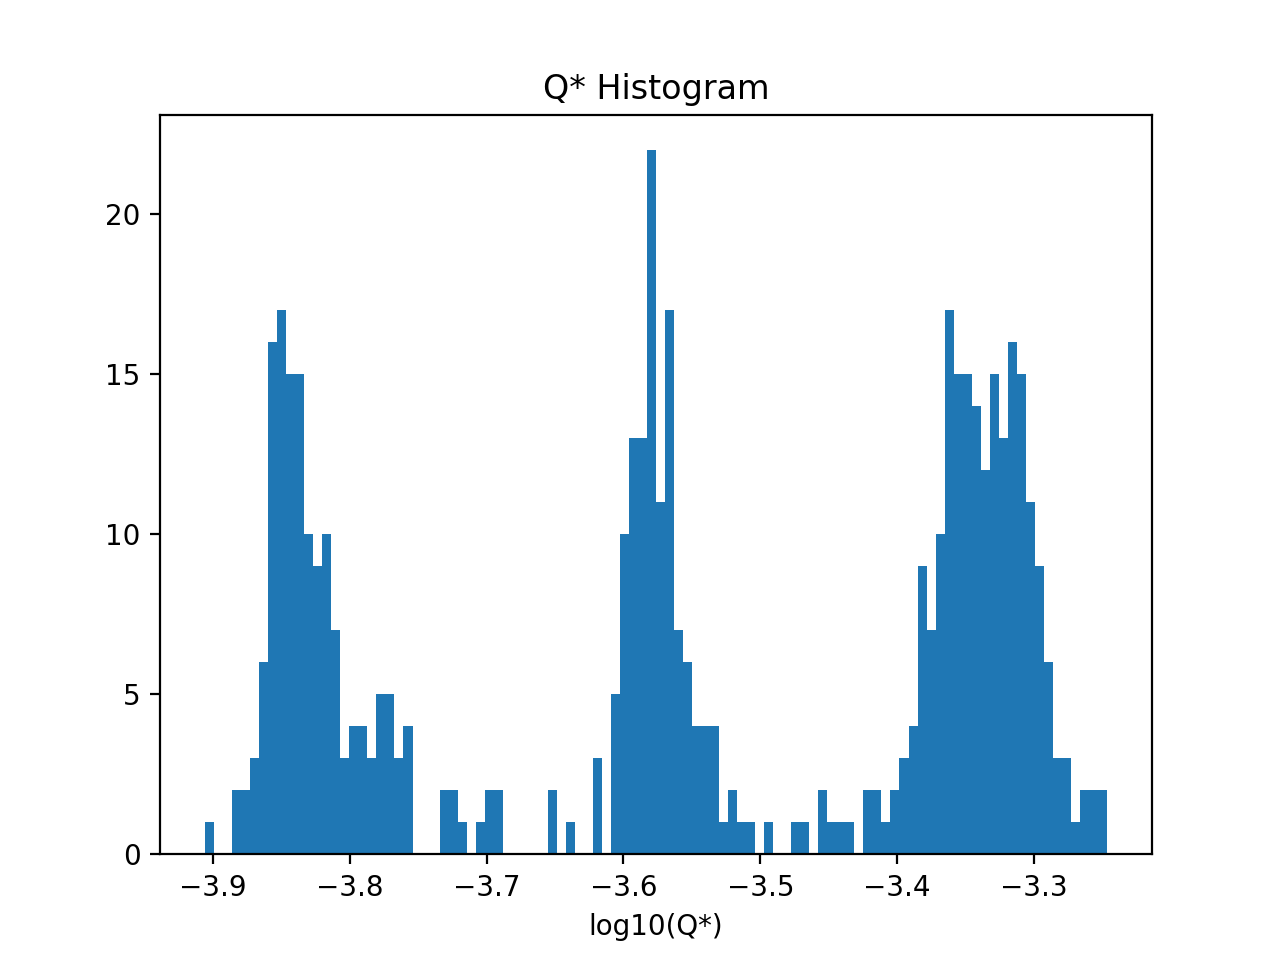

<IPython.core.display.Javascript object>


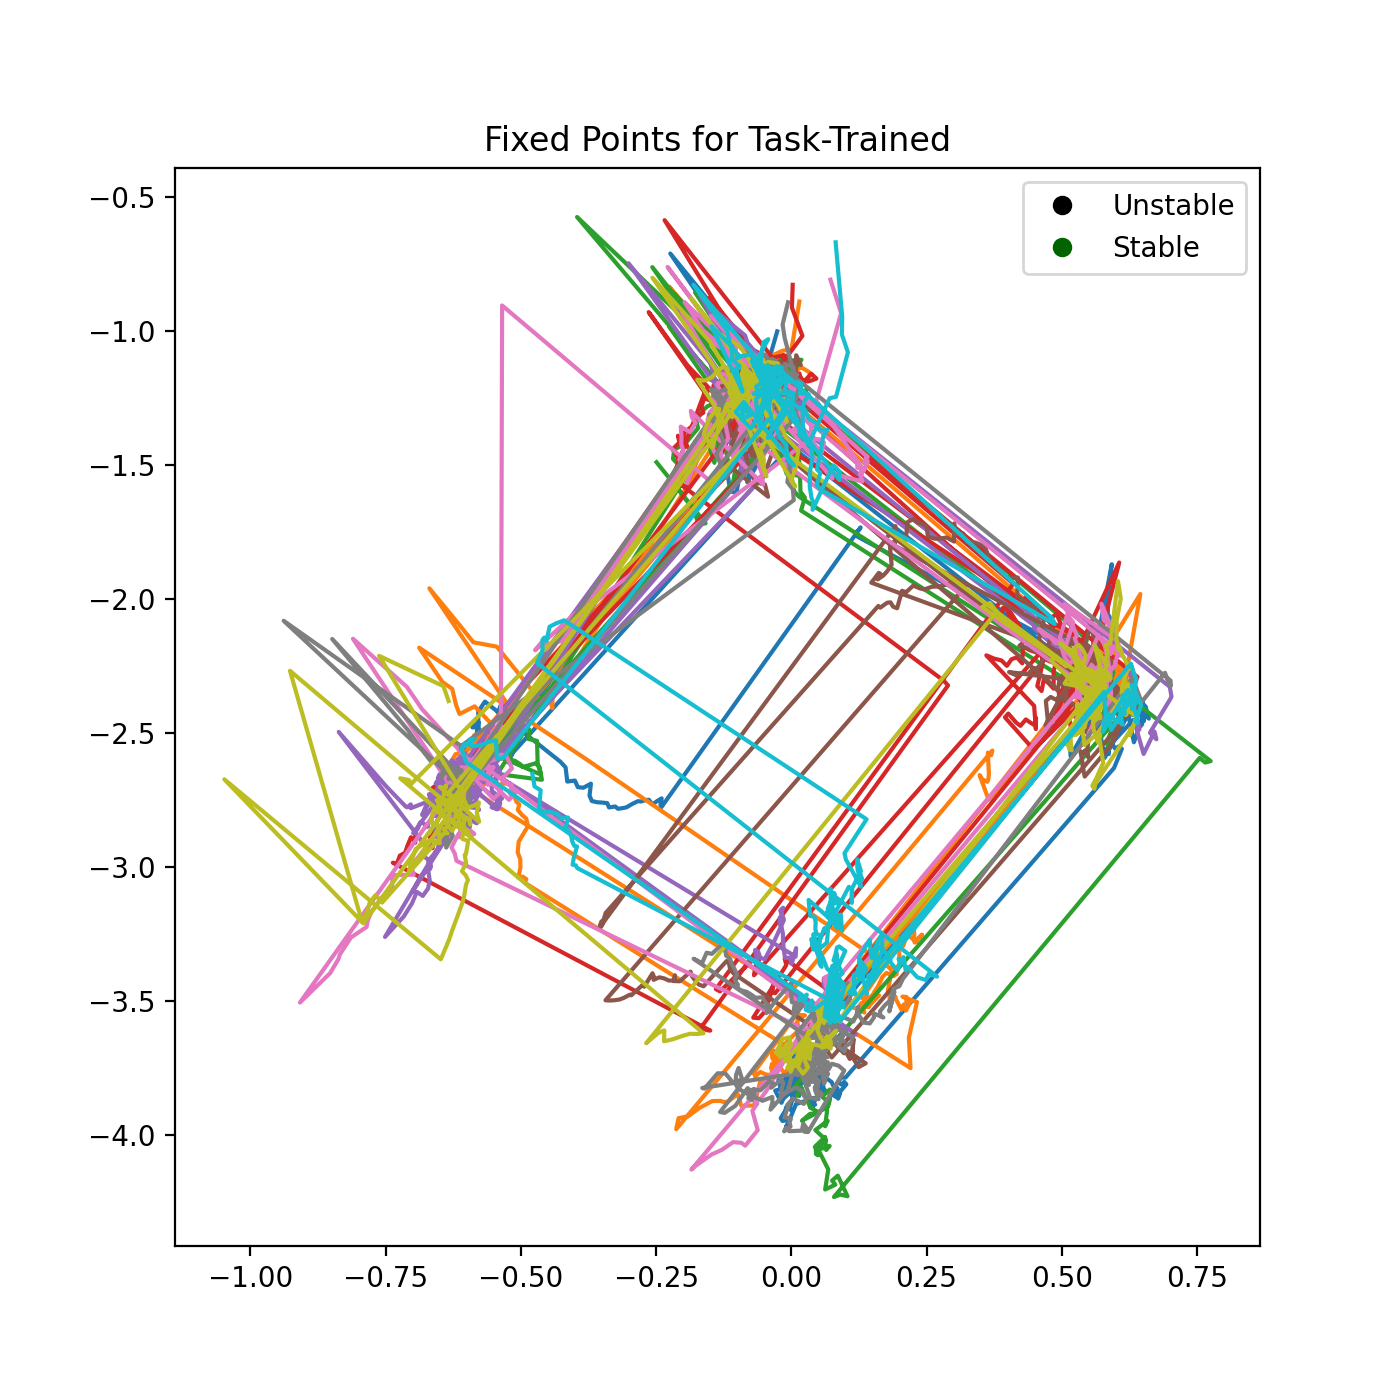

In [38]:
# VERIFY THAT MY VELOCITY FIELD WORKS
path = "/scratch/network/ad2002/content/trained_models/task-trained/20240406_NODE_2BFF_300epoch/latent_size=2 weight_decay=1e-08 learning_rate=0.001 max_epochs=300 log_every_n_steps=1 seed=0 batch_size=64 num_workers=1 n_samples=300 n=2 n=2/"
node_2BFF_2D = Analysis_TT(run_name = "node_2bff_known", filepath = path)

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,2))

velocity_vectors, xstar, q_flag, color = node_2BFF_2D.plot_fps(
    inputs= my_inputs,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=500,
    learning_rate=1e-5,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-6,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True
)


In [46]:
num_points = 20
latent_range = [[-1,1], [-4,0]]

my_inputs = -1*torch.zeros(num_points**2, 2)

# fig, ax = node_2BFF_2D.plot_velocity_field_non_pca(my_inputs, latent_range, num_points, xstar, q_flag, color, 
#                                         num_traj=1, cmap=plt.cm.Reds, return_animation=True, validate_input_val=None)

empties = node_2BFF_2D.get_empty_input_latents(0)
print(empties.shape)

#plt.plot(empties[:,0], empties[:,1])


(1000, 500, 2)


### NODE: latent size = 3

* weight decay 1e-10
* learning rate 1e-2
* 300 epochs
* n=20 (average pulses in trial)

In [32]:
path = "/scratch/network/ad2002/content/trained_models/task-trained/20240422_NODE_OBS3D_300epoch/latent_size=3 layer_hidden_size=100 num_layers=3 weight_decay=1e-10 learning_rate=0.01 max_epochs=300 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS_3D = Analysis_TT(run_name = "node_obs_test", filepath = path)

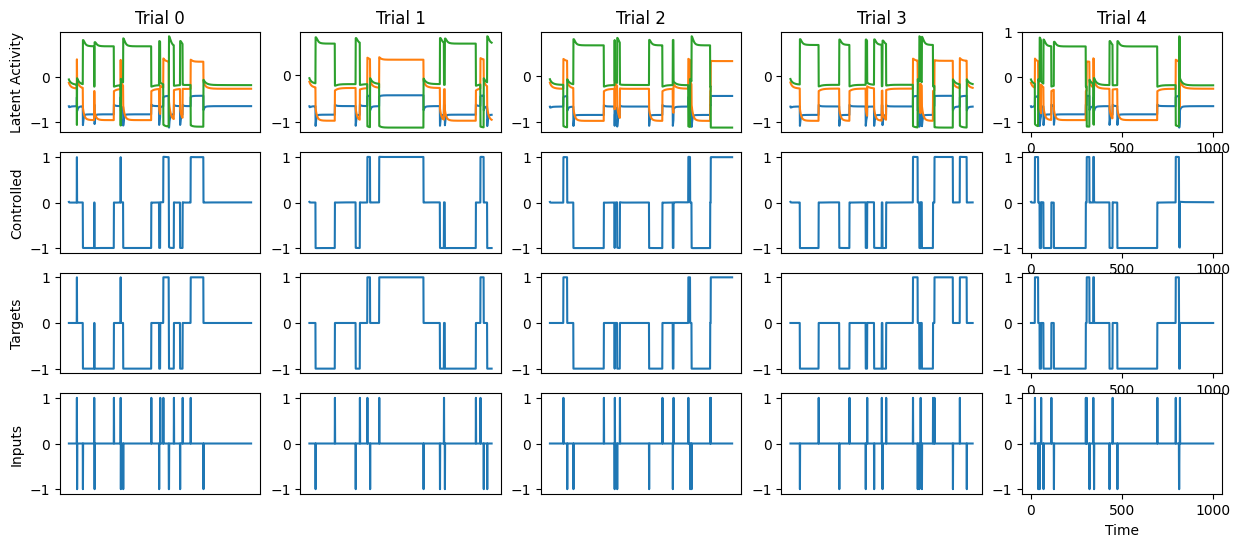

In [33]:
node_OBS_3D.plot_trial_io_no_pca(num_trials=5, latent_size=3)

Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


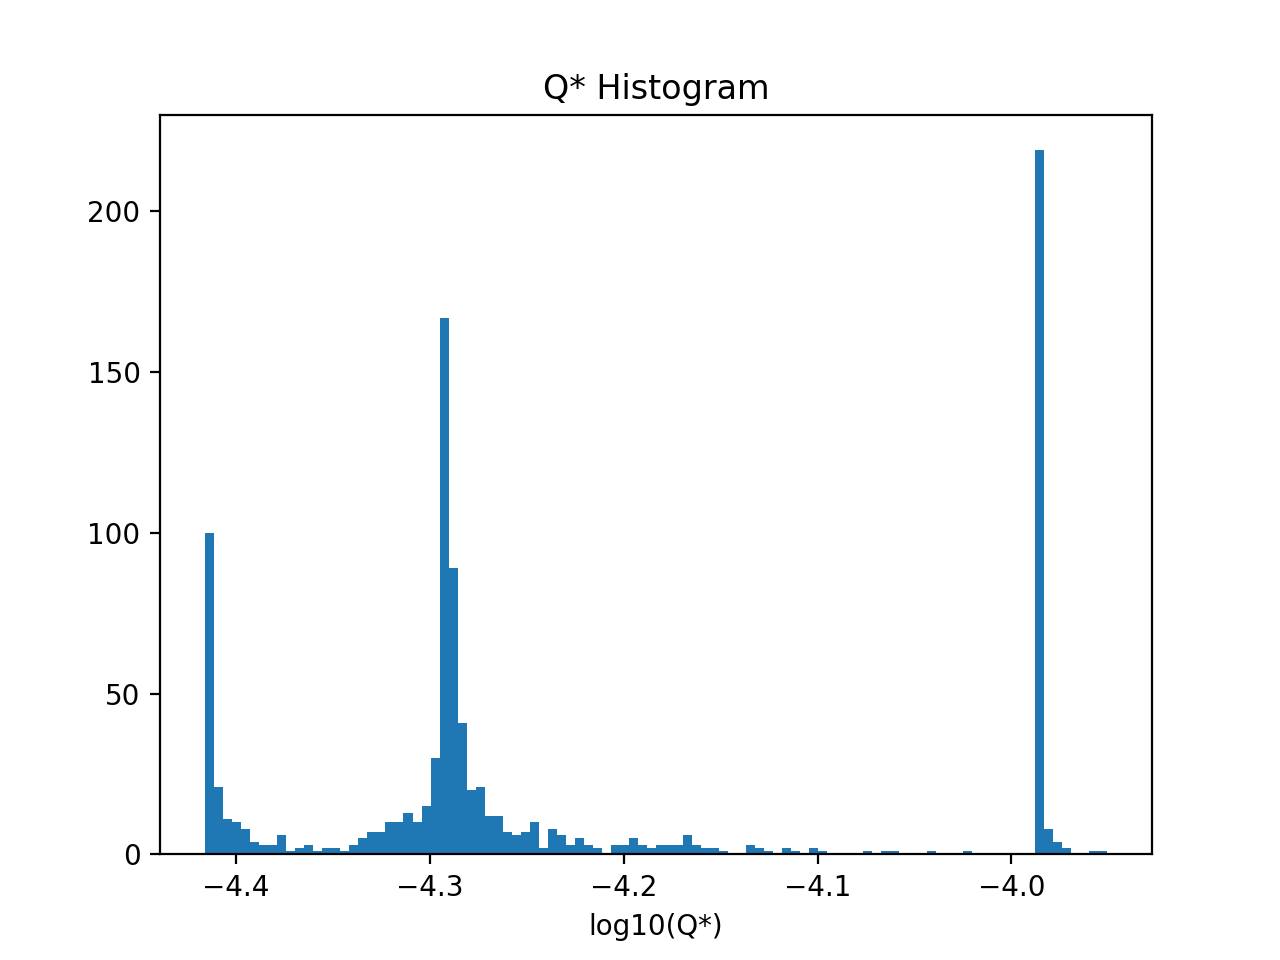

<IPython.core.display.Javascript object>


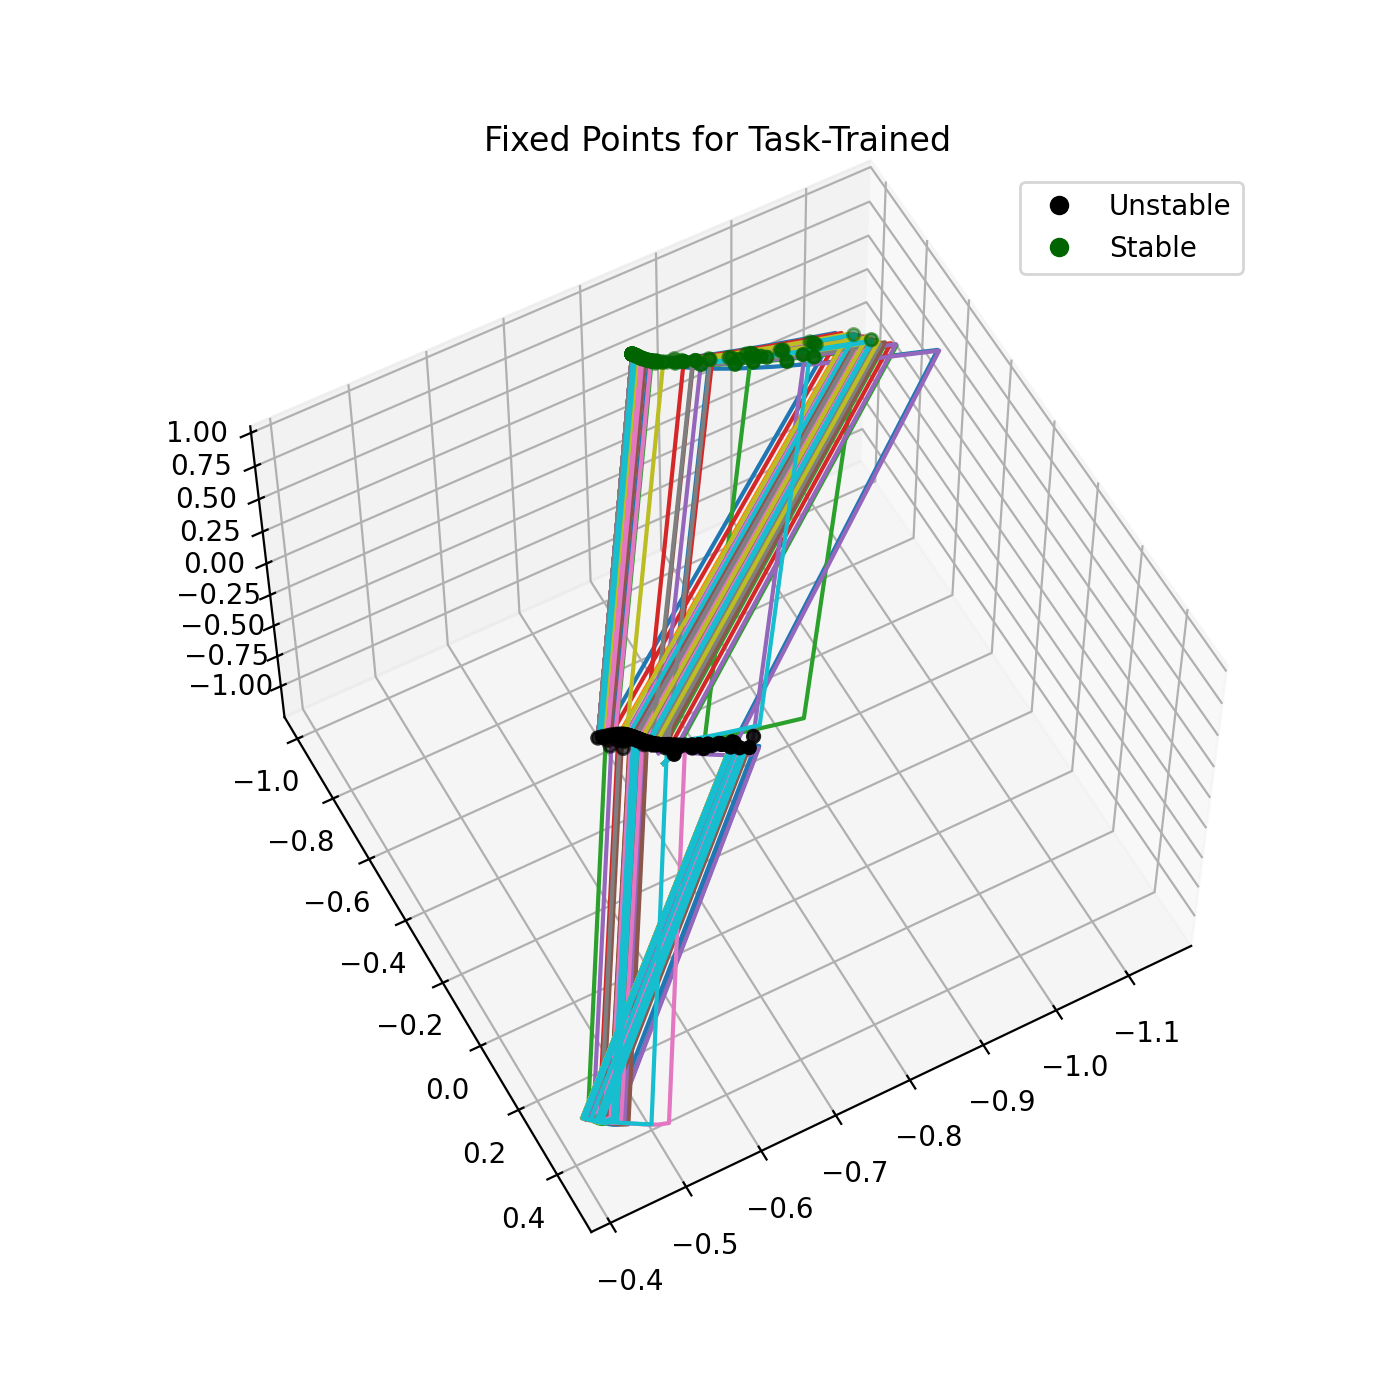

In [34]:
%matplotlib notebook

my_inputs = torch.zeros_like(torch.empty(1000,1000,1))

velocity_vectors, xstar, q_flag, color = node_OBS_3D.plot_fps(
    inputs= my_inputs,  
    n_inits=1000,
    learning_rate=1e-7,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,        # big difference from 1e-4 to 1e-5
    n_pca_components = 3,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)

Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


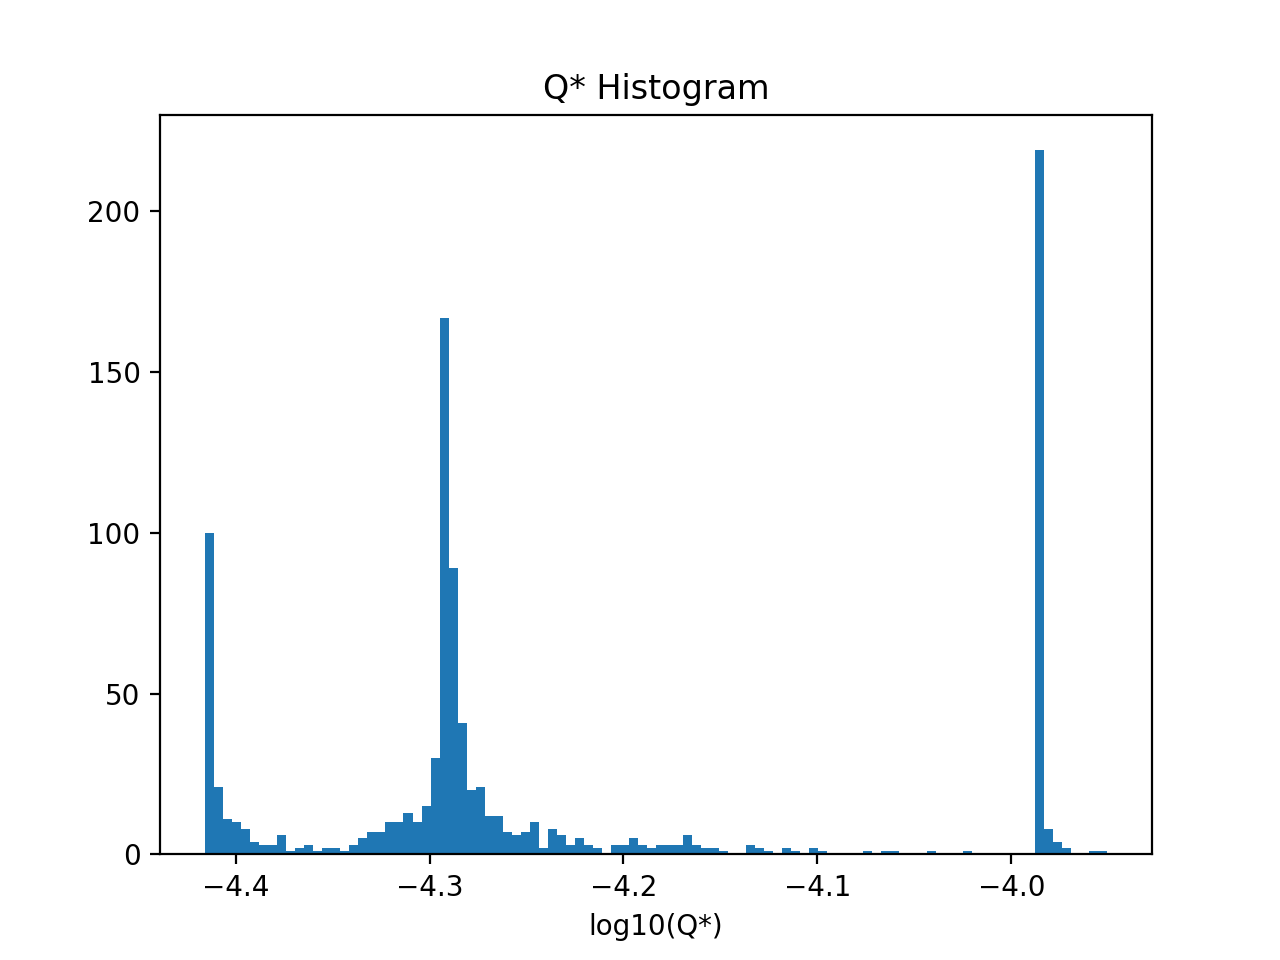

<IPython.core.display.Javascript object>


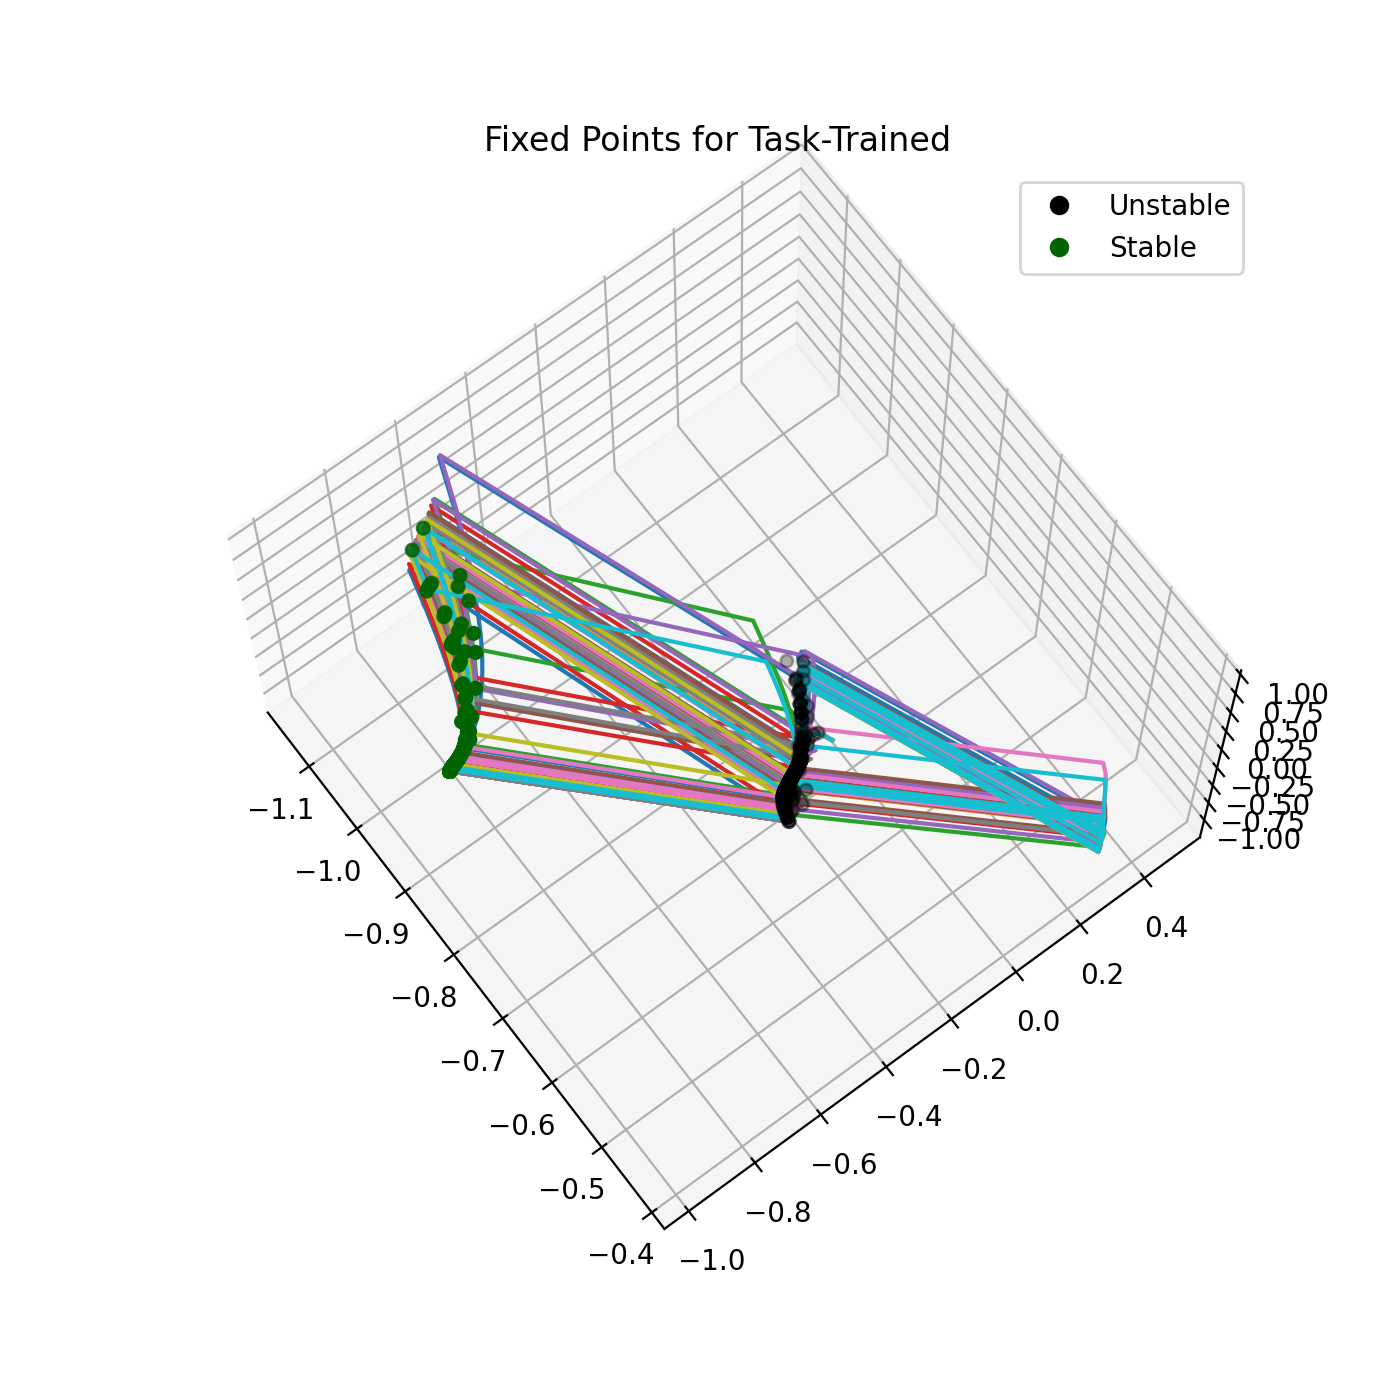

In [37]:
my_inputs = torch.zeros_like(torch.empty(1000,1000,1))

velocity_vectors, xstar, q_flag, color = node_OBS_3D.plot_fps(
    inputs= my_inputs,  
    n_inits=1000,
    learning_rate=1e-12,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,        # big difference from 1e-4 to 1e-5
    n_pca_components = 3,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)

<IPython.core.display.Javascript object>


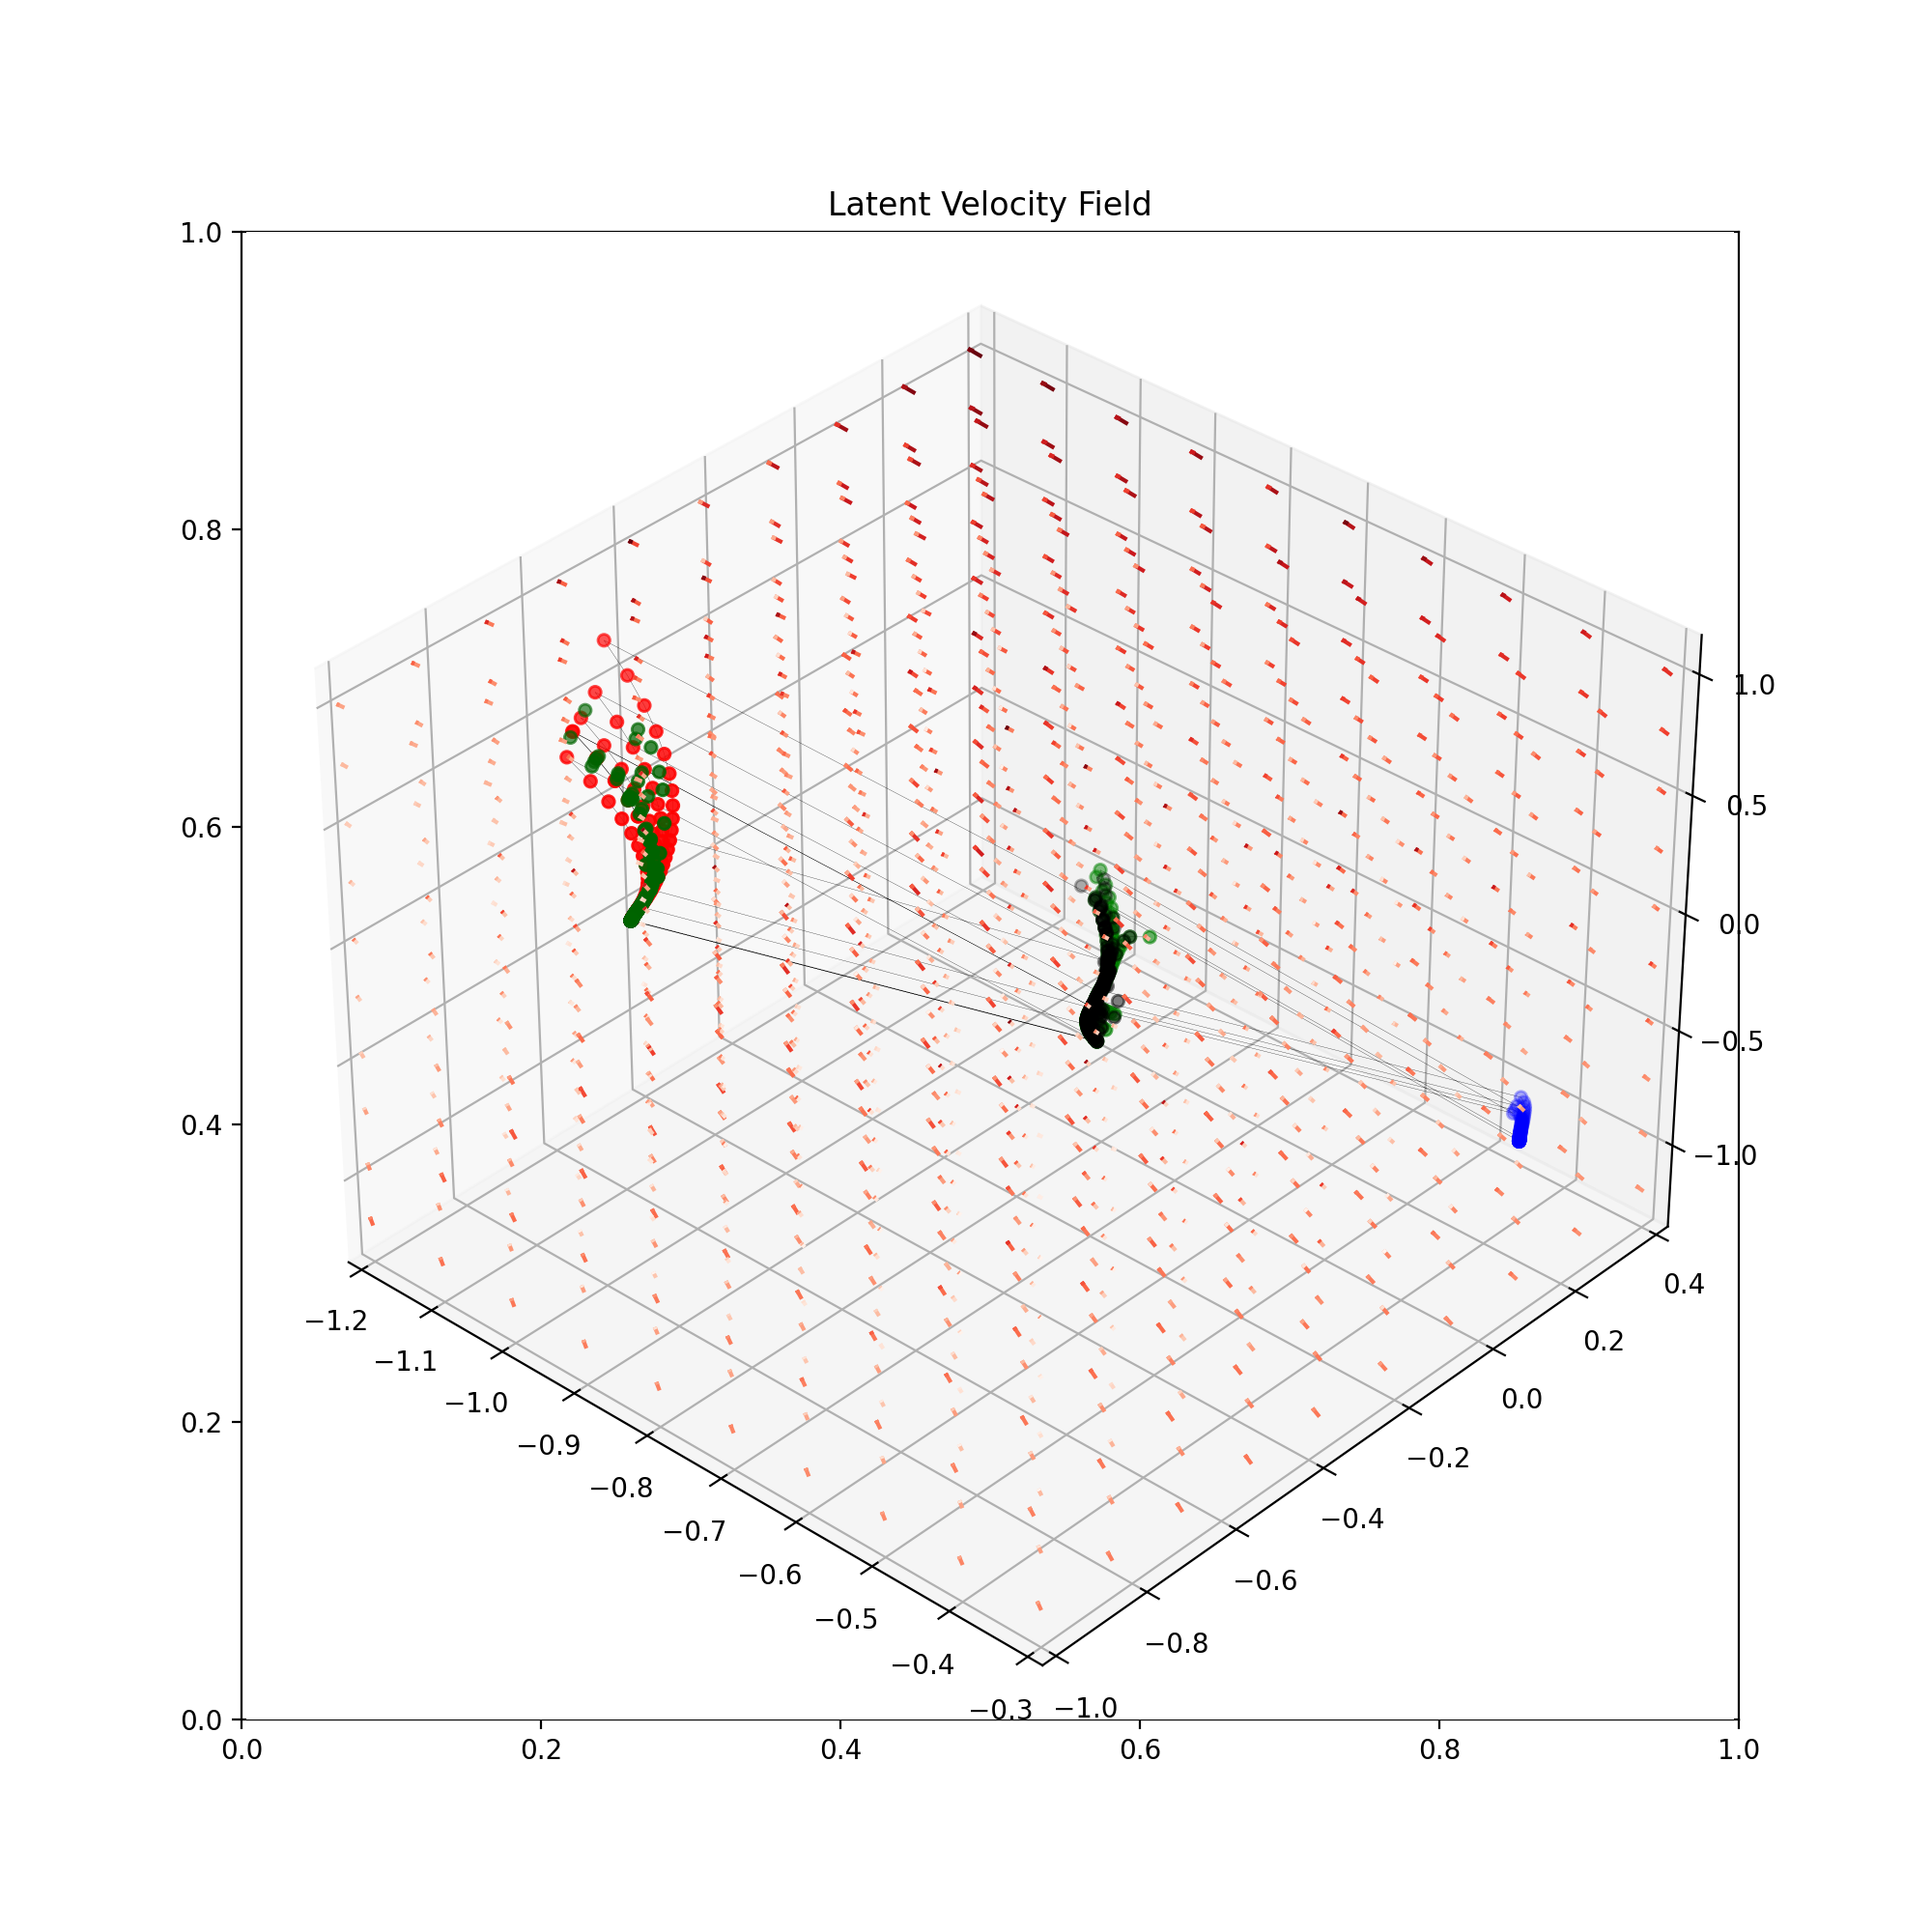

In [35]:
# plot the velocity field
%matplotlib notebook

num_points = 10
latent_range = [[-1.2,-0.3],[-1,0.4],[-1.2,1]]

# inputs has to match the number of coordinates along the first dimension
# (or match the first 2 directions if passing in trajectories, not single points)
my_inputs = torch.zeros_like(torch.empty(num_points**3, 1))

# now running it without inputs

node_OBS_3D.plot_velocity_field_non_pca(my_inputs, latent_range, num_points, xstar, q_flag, color, num_traj=1, cmap=plt.cm.Reds)

## Hyperparameter tuning for the models

### NODE on 3BFF

In [ ]:
def plot_loss_curves(directory, n_epochs, start_epochs=0):
    
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    for file in csv_files:
        file = directory+file
        # Load the data
        with open(file, 'r') as f:
            data = pd.read_csv(f)
    
        # Fill missing values with the previous ones
        data.ffill(inplace=True)
    
        # Plot validation loss - 300 is max number of epochs shared by the 30+ tune sets
        plt.figure(figsize=(10, 5))
        plt.plot(data['epoch'][start_epochs:n_epochs], data['valid/loss'][start_epochs:n_epochs], label='Test(valid) Loss')
    
        # Plot test loss
        plt.plot(data['epoch'][start_epochs:n_epochs], data['train/loss'][start_epochs:n_epochs], label='Train Loss')
    
        # Extract parameters from the filename
        parameters = file.split(',')  # Change this if your delimiter is not an underscore
        parameters[-1] = parameters[-1].replace('.csv', '')  # Remove the .csv extension from the last parameter
        title = ' '.join(parameters)
    
        plt.title(f'Validation and Test Loss Over Epochs for {title}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.show()
    

In [ ]:
directory = 'node_3bff_metrics/'
plot_loss_curves(directory, 300)

# OBSERVATIONS
# NODE for 3BFF is clearly NOT overfitting in any case - it might be underfitting - how to tell?

# most optimal of 300: set 21
# latent size 6
# batch 64
# learning 0.001
# weight decay: 

### Vanilla on 3BFF

In [ ]:
directory = 'vanilla_3bff_metrics/'
plot_loss_curves(directory, 300)

# never seems to go below 0.2

### Node on OBS

In [ ]:
directory = 'node_obs_metrics/'
plot_loss_curves(directory, 1500, start_epochs=10)

# maybe set 7 seems the best

In [ ]:
directory = 'gru_obs_metrics/'
plot_loss_curves(directory, 1500, 10)

# interest slow start then drop

# learning rate seems to be the determinant factor for GRU, while the weight decay seems more important for NODE

## PREVIOUS runs: One Bit Sum - OBS

Similar to the PClicks task that rats do in the Brody Lab. We have a train of spikes at constant intervals of time where the cumulative sum lies between a pre-determined range. The output should be the sign of the cumulative sum since t = 0.

### CORRECTION: the results below are not really accurate. The inputs are not sparse and there is no time for memorization - the network oscillates erratically between points and used the immediate dynamics

### NODE: latent size = 2

In [ ]:
# NODE on OBS - worked better for the highest learning rate and lowest weight decay

path = "/scratch/network/ad2002/content/trained_models/task-trained/20240419_NODE_OBS_200epoch_2D/latent_size=2 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.001 max_epochs=200 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS = Analysis_TT(run_name = "node_obs_test", filepath = path)

In [ ]:
# plot dimensions without pca

node_OBS.plot_trial_io_no_pca(num_trials=5, latent_size=2)

In [ ]:
# basically one latent seems to be solving the task (as one could expect...)

node_OBS.plot_trial_io(num_trials=3, n_pca_components=2)

In [ ]:
# plot the fixed points

# higher learning rate and low threshold is the way to go
# NOTE that increasing the inits past 1000 starts to distort the results
# stable points do not seem to reach threshold below 1e-5

# NOTE the networks that could not solve the task have a curve of trajectories outlined by unstable points and 
# ending on some stable ones

fps_OBS, xstar, q_flag, color = node_OBS.plot_fps(
    inputs= None,  
    n_inits=1000,
    learning_rate=1e-4,
    noise_scale=0,
    max_iters=100000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)

In [ ]:
# shape of inputs is 
node_OBS.explore_params()

num_points = 20
latent_range = [[-2,5], [-2,5]]

# inputs has to match the number of coordinates along the first dimension
# (or match the first 2 directions if passing in trajectories, not single points)
inputs = torch.empty(num_points**2,1)
inputs = -1*torch.ones_like(inputs)

# Define the size of the tensor
size = (num_points**2, 1)

# # Generate a tensor with random integers in the range [0, 2]
# random_integers = torch.randint(0, 3, size)
# values_mapping = torch.tensor([-1, 0, 1])
# inputs = values_mapping[random_integers]

node_OBS.plot_velocity_field_non_pca(inputs, latent_range, num_points, xstar, q_flag, color, num_traj=1)

# 1000 - n_samples from task datamodule_train configs - here I just need 1 sample (this is the number of trials)
# 500 - n_timesteps from env_task configs
# I want 20*20,2

### NODE: latent size = 3

In [ ]:
# NODE on OBS - worked better for the highest learning rate and lowest weight decay

path = "/scratch/network/ad2002/content/trained_models/task-trained/20240421_NODE_OBS_200epoch_3D/latent_size=3 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.01 max_epochs=200 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS_3D = Analysis_TT(run_name = "node_obs_test", filepath = path)

In [ ]:
# again all the activity seems to be contained in 1 latents
# MSE ~ 0.001 it solves it better in less time, but surely NODE in 2D can get the same with more epochs

node_OBS_3D.plot_trial_io_no_pca(num_trials=3, latent_size=3)

In [ ]:
fps_OBS_3D, xstar, q_flag, color = node_OBS_3D.plot_fps(
    inputs= None,  
    n_inits=1000,
    learning_rate=1e-3,
    noise_scale=0,
    max_iters=10000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,
    n_pca_components = 3,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)